<a href="https://colab.research.google.com/github/reccos7/projects_publicdata/blob/main/trafficsign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
N_CLASSES = 43   #범주 개수
RESIZED_IMAGE = (32,32)   #이미지 크기

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import cv2
np.random.seed(101)
%matplotlib inline

In [3]:
#zip 폴더 불러오기 & 압축 풀기
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip GTSRB_Final_Training_Images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: GTSRB/Final_Training/Images/00035/00000_00019.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_0

In [4]:
#데이터 전처리 (읽기, 변환, 사이즈 조정)

Dataset = namedtuple('Dataset',['X','y'])

def to_tf_format(imgs):
  return np.stack([img[:,:,np.newaxis] for img in imgs], axis=0).astype(np.float32)
def read_dataset_ppm(rootpath, n_labels, resize_to):
  images=[]
  labels=[]
  for c in range(n_labels):
    full_path=rootpath+'/'+format(c,'05d') + '/'
    for img_name in glob.glob(full_path+"*.ppm"):
      img=plt.imread(img_name).astype(np.float32)
      #원래의 색 공간을 lab 색 공간으로 변환
      img=rgb2lab(img/255.0)[:,:,0]
      if resize_to:
        img=resize(img, resize_to, mode='reflect')
      label=np.zeros((n_labels,), dtype=np.float32)
      label[c]=1.0
      images.append(img.astype(np.float32))
      labels.append(label)

  return Dataset(X= to_tf_format(images).astype(np.float32),
                 y=np.matrix(labels).astype(np.float32))

dataset=read_dataset_ppm('GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
print("Input Shape: ", dataset.X.shape)
print("Target Shape: ", dataset.y.shape)

Input Shape:  (39209, 32, 32, 1)
Target Shape:  (39209, 43)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


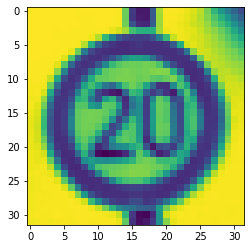

In [5]:
#첫번째 표본
plt.imshow(dataset.X[0,:,:,:].reshape(RESIZED_IMAGE))
print(dataset.y[0,:])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


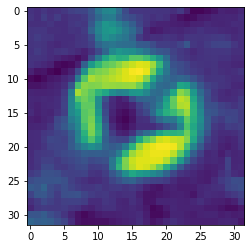

In [6]:
#마지막 표본
plt.imshow(dataset.X[-1,:,:,:].reshape(RESIZED_IMAGE))
print(dataset.y[-1,:])

In [7]:
#훈련 데이터 & 테스트 데이터 분할

from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train=dataset.X[idx_train,:,:,:]
X_test=dataset.X[idx_test,:,:,:]
y_train = dataset.y[idx_train,:]
y_test= dataset.y[idx_test,:]

print("Input Train Data: ", X_train.shape)
print("Target Train Data: ", y_train.shape)
print("Input Test Data: ", X_test.shape)
print("Target Test Data: ", y_test.shape)

Input Train Data:  (29406, 32, 32, 1)
Target Train Data:  (29406, 43)
Input Test Data:  (9803, 32, 32, 1)
Target Test Data:  (9803, 43)


In [8]:
#신경망 구축
model=keras.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=5, input_shape=(32,32,1), padding='same'))
model.add(keras.layers.MaxPooling2D(2, strides=2, padding='same'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(64,kernel_size=5, padding='same'))
model.add(keras.layers.MaxPooling2D(2,strides=2, padding='same'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, kernel_initializer=keras.initializers.GlorotNormal(), bias_initializer='zeros'))
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(43,  activation= 'softmax', kernel_initializer=keras.initializers.GlorotNormal(),bias_initializer='zeros'))

In [9]:
keras.optimizers.Adam(learning_rate=0.001, name='adam')
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(X_train,y_train,epochs=10, batch_size=256, validation_data=(X_test,y_test))

Epoch 1/10
115/115 [==============================] - 31s 32ms/step - loss: 7.3421 - accuracy: 0.4689 - val_loss: 3.5630 - val_accuracy: 0.4938
Epoch 2/10
115/115 [==============================] - 3s 28ms/step - loss: 0.7234 - accuracy: 0.8129 - val_loss: 0.6749 - val_accuracy: 0.8525
Epoch 3/10
115/115 [==============================] - 3s 28ms/step - loss: 0.4328 - accuracy: 0.8849 - val_loss: 0.2467 - val_accuracy: 0.9414
Epoch 4/10
115/115 [==============================] - 3s 28ms/step - loss: 0.2941 - accuracy: 0.9223 - val_loss: 0.2186 - val_accuracy: 0.9492
Epoch 5/10
115/115 [==============================] - 3s 28ms/step - loss: 0.2414 - accuracy: 0.9362 - val_loss: 0.1482 - val_accuracy: 0.9663
Epoch 6/10
115/115 [==============================] - 3s 28ms/step - loss: 0.1740 - accuracy: 0.9521 - val_loss: 0.1283 - val_accuracy: 0.9740
Epoch 7/10
115/115 [==============================] - 3s 28ms/step - loss: 0.1560 - accuracy: 0.9579 - val_loss: 0.1218 - val_accuracy: 0.974

In [10]:
model.evaluate(X_test,y_test)

307/307 [==============================] - 2s 5ms/step - loss: 0.1029 - accuracy: 0.9776


[0.10290572047233582, 0.977557897567749]

In [11]:
y_test_pred= model.predict(X_test)
y_test_pred_classified = np.argmax(y_test_pred, axis=1)
y_test_true_classified = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred_classified, y_test_true_classified))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        67
           1       0.91      1.00      0.95       494
           2       1.00      0.96      0.98       577
           3       0.92      0.99      0.95       340
           4       1.00      0.93      0.96       526
           5       0.96      0.94      0.95       491
           6       1.00      1.00      1.00       105
           7       0.90      0.99      0.94       331
           8       0.99      0.89      0.94       379
           9       0.97      0.99      0.98       375
          10       0.99      0.98      0.99       517
          11       0.97      0.99      0.98       328
          12       1.00      0.99      1.00       546
          13       0.99      1.00      0.99       533
          14       1.00      0.99      0.99       215
          15       1.00      0.98      0.99       167
          16       1.00      0.98      0.99       100
          17       0.99    

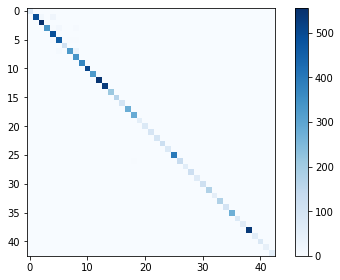

In [12]:
cm=confusion_matrix(y_test_true_classified, y_test_pred_classified)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
plt.show()

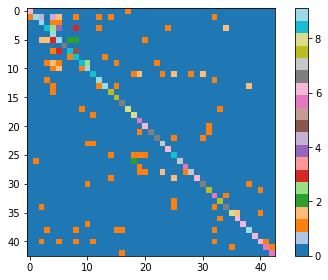

In [13]:
plt.imshow(np.log2(cm+1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
plt.colorbar()
plt.tight_layout()
plt.show()

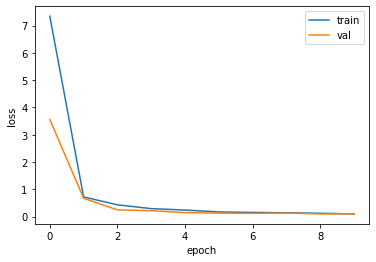

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()